In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D, Dropout, Flatten, ReLU, Add, BatchNormalization, AveragePooling2D, Multiply, GlobalAveragePooling2D, Reshape,DepthwiseConv2D
from keras.optimizers import RMSprop
import keras.backend as K
import cv2
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from PIL import Image
from tensorflow.keras.metrics import Metric,Precision, Recall
from keras.utils.vis_utils import plot_model

In [2]:
train_dir = r'E:\MV\coursework\fruits-360\Training'
test_dir = r'E:\MV\coursework\fruits-360\Test'
#The total number of images: 90483.
#Training set size: 67692 images (one fruit or vegetable per image).
#Test set size: 22688 images (one fruit or vegetable per image).
#The number of classes: 131 (fruits and vegetables).
#Image size: 100x100 pixels.

In [3]:
#find out the total calsses of dataset.
className = glob.glob(train_dir + "/*")
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  131


In [4]:
def denoise_background(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    np.copyto(image, thresh_rgb, where=thresh_rgb == 255)
    return image

In [5]:
# Load and preprocess the training data
train_datagen = ImageDataGenerator(
    preprocessing_function=denoise_background,
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.068,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='training' 
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100,100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb', 
    subset='validation'
)

# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100,100),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 63145 images belonging to 131 classes.
Found 4547 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [6]:
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()

In [7]:
input_shape = Input(shape=(100,100,3))

In [8]:
class CustomAccuracy(Metric):
    def __init__(self, name='accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true_classes = tf.argmax(y_true, axis=1)
        correct_predictions = tf.equal(y_pred_classes, y_true_classes)
        correct_predictions = tf.cast(correct_predictions, 'float32')
        
        self.correct.assign_add(tf.reduce_sum(correct_predictions))
        self.total.assign_add(tf.cast(tf.size(y_true_classes), 'float32'))

    def result(self):
        return tf.divide(self.correct, self.total)

    def reset_state(self):
        self.correct.assign(0)
        self.total.assign(0)


In [9]:
class CustomCrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, name='loss', **kwargs):
        super(CustomCrossEntropyLoss, self).__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        epsilon = 1e-10
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

        return loss

Model 1: 3 inception block +SE  

Model2: 4 res_block+DepthwiseConv+SE

In [10]:
def se_block(input_tensor, ratio=16):
# Squeeze-and-Excitation block
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    scaled_input = Multiply()([input_tensor, se])
    return scaled_input

def inception_block(x, br1, br2_1, br2_2, br3_1, br3_2, br4):
    # Branch 1
    branch1 = Conv2D(br1, (1, 1), padding='same', activation='relu')(x)
    # Branch 2 3x3-> 1x3 3x1
    branch2 = Conv2D(br2_1, (1, 1), padding='same', activation='relu')(x)
    #branch2 = Conv2D(br2_2, (3, 3), padding='same', activation='relu')(branch2)
    branch2 = Conv2D(br2_2, (1, 3), padding='same', activation='relu')(branch2)
    branch2 = Conv2D(br2_2, (3, 1), padding='same', activation='relu')(branch2)
    # Branch 3 5x5->3x3 3x3-> 1x3 3x1 1x3 3x1 
    branch3 = Conv2D(br3_1, (1, 1), padding='same', activation='relu')(x)
    #branch3 = Conv2D(br3_2, (5, 5), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (1, 3), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (3, 1), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (1, 3), padding='same', activation='relu')(branch3)
    branch3 = Conv2D(br3_2, (3, 1), padding='same', activation='relu')(branch3)
    # Branch 4
    branch4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = Conv2D(br4, (1, 1), padding='same', activation='relu')(branch4)
    # Concatenate all the branches
    branch_output = concatenate([branch1, branch2, branch3, branch4], axis=-1)
    # After the Inception block, apply the SE block
    branch_output = se_block(branch_output)
    return branch_output

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_shape)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 64, 96, 64, 16, 32, 32)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 128, 128, 128, 32, 64, 64)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = inception_block(x, 160, 160, 160, 48, 96, 96)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
# Final layers
x = GlobalAveragePooling2D()(x)
output = Dense(numberOfClass, activation='softmax')(x)
model_1 = Model(inputs=input_shape, outputs=output)


def res_block(input_tensor, filters, strides=1):
    shortcut = input_tensor

    # First component of main path
    x = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second component of main path
    x = DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1)(x)
    x = Conv2D(filters, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third component of main path
    x = Conv2D(filters * 4, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = se_block(x)

    # Shortcut path
    if strides != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = Conv2D(filters * 4, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Final step: Add shortcut value to main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


def combined_model():

    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(2,2)(x)

    x = res_block(x, filters=64, strides=1)
    x = res_block(x, filters=128, strides=2)
    x = res_block(x, filters=256, strides=2)
    x = res_block(x, filters=512, strides=2)
    x = MaxPooling2D(2,2)(x)

    x = GlobalAveragePooling2D()(x)
    output = Dense(numberOfClass, activation='softmax')(x)

    model_2 = Model(inputs=input_shape, outputs=output)
    concatenated_output= concatenate([model_1.output, model_2.output])

    x = Dense(128, activation='relu')(concatenated_output) 
    x = BatchNormalization()(x) 
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x) 
    x = Dropout(0.3)(x)
    ensemble_output= Dense(numberOfClass, activation='softmax')(x)
    #Build the ensemble model
    combined_model = Model(inputs=input_shape, outputs= ensemble_output)
    return combined_model

Compile the model

In [11]:
combined_model=combined_model()
#Build the ensemble model
combined_model.compile(optimizer=RMSprop(learning_rate=0.001), loss=CustomCrossEntropyLoss(),metrics=[CustomAccuracy()])

Train and seve the models

In [12]:
epochs_to_save = [10, 20, 30, 40, 50]
saved_models = {}

for epoch in range(1, 51):
    history=combined_model.fit(train_generator, epochs=1, validation_data=validation_generator)

    if epoch in epochs_to_save:
        saved_models[epoch] = combined_model.get_weights()


1974/1974 [==============================] - 337s 170ms/step - loss: 0.0245 - accuracy: 0.9963 - val_loss: 0.1532 - val_accuracy: 0.9820


Evaluate the models with different epoch settings

In [15]:
evaluation_results = {}

for epoch, weights in saved_models.items():
    combined_model.set_weights(weights)
    loss, accuracy = combined_model.evaluate(test_generator)
    evaluation_results[epoch] = accuracy


709/709 [==============================] - 30s 42ms/step - loss: 0.4208 - accuracy: 0.9581


Show the evaluation results

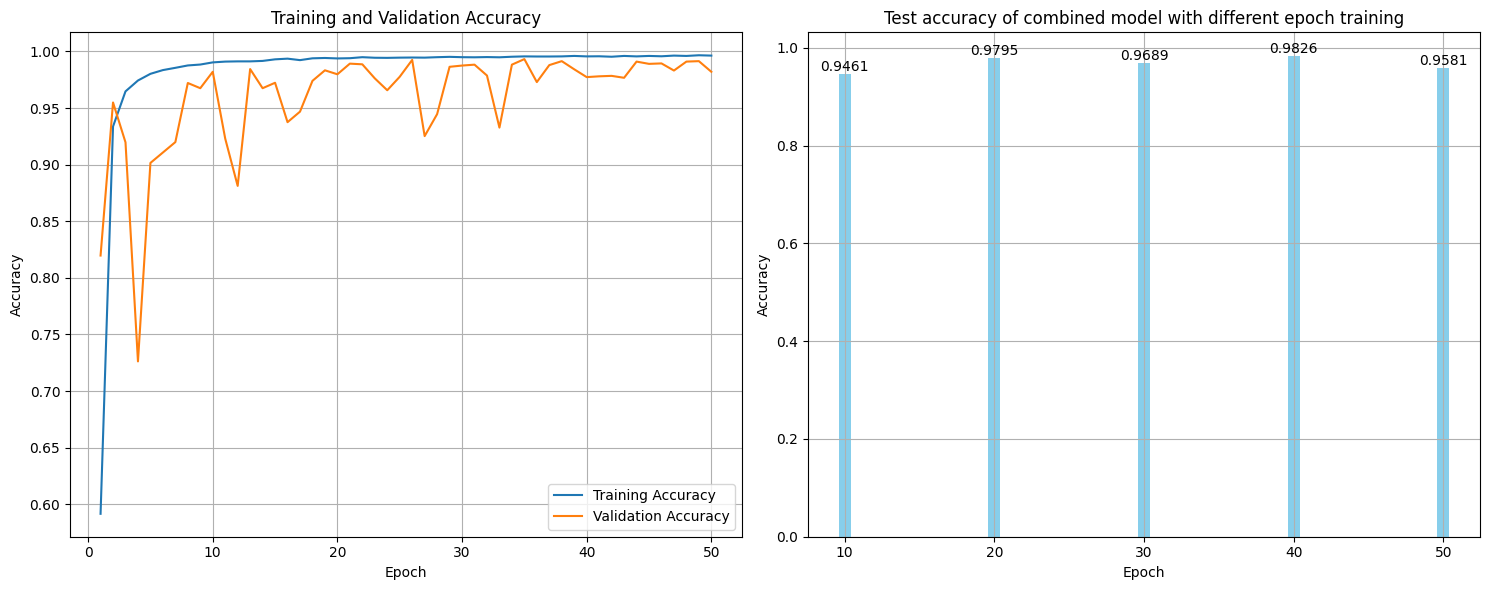

In [19]:
import re

file_path = 'Training history for the epoch experiment.txt'

# read the output from the training history
with open(file_path, 'r') as file:
    training_output = file.read()

# find the accuracy in each epoch
pattern = r"accuracy: (\d\.\d+) - val_loss: \d\.\d+ - val_accuracy: (\d\.\d+)"
matches = re.findall(pattern, training_output)

# separate training and validation accuracies
train_accuracies, val_accuracies = zip(*matches)
train_accuracies = [float(acc) for acc in train_accuracies]
val_accuracies = [float(acc) for acc in val_accuracies]

# plot training and validation accuracies
epochs = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(15, 6))

# subplot 1 for training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# subplot 2 for test accuracy
plt.subplot(1, 2, 2)

# Assuming evaluation_results is defined somewhere in your code
epochs = list(evaluation_results.keys())
accuracies = list(evaluation_results.values())

bars = plt.bar(epochs, accuracies, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

plt.title('Test accuracy of combined model with different epoch training')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.ylabel('Accuracy')
plt.grid(True)

# adjust layout for better spacing
plt.tight_layout()

plt.show()
